# Generate spatially varying magnitude errors according to observing conditions

The ObsCondition degrader can be used to generate spatially-varying photometric errors using input survey condition maps in `healpix` format, such as survey coadd depth, airmass, sky brightness etc. The photometric error is computed by `photerr.LsstErrorModel`, based on the LSST Overview Paper:
https://arxiv.org/abs/0805.2366. The degrader assigns each object in the input catalogue with a pixel within the survey footprint and computes the magnitude error (SNR) on each pixel. Unprovided arguments takes the default values in the LSST Overview Paper. 

The degrader takes the following arguments:

- `nside`: nside used for the HEALPIX maps.
- `mask`: Path to the mask covering the survey footprint in HEALPIX format. Notice that all negative values will be set to zero.
- `weight`: Path to the weights HEALPIX format, used to assign sample galaxies in pixels. Default is weight="", which uniform weighting.
- `tot_nVis_flag`: If `nVisYr` is provided in `map_dict` (see below), this flag indicates whether the map shows the total number of visits in nYrObs (tot_nVis_flag=True), or the average number of visits per year (tot_nVis_flag=False). The default is set to True.   
- `random_seed`: A random seed for reproducibility.
- `map_dict`: A dictionary that contains the paths to the survey condition maps in HEALPIX format. This dictionary uses the same arguments as LSSTErrorModel. The following arguements, if supplied, may contain either a single number (as in the case of LSSTErrorModel), or a path to the corresponding survey condition map in `healpix` format:`m5`, `nVisYr`, `airmass`, `gamma`, `msky`, `theta`, `km`, and `tvis`. Notice that *except* `airmass` and `tvis`, for all other arguements, numbers/paths for *specific bands* should be passed. Other `LsstErrorModel` parameters can also be passed in this dictionary (e.g. a necessary one may be `nYrObs` for the survey condition maps; the default value is 10 years, although most  may be interested in early data releases). If any arguement is not passed, the default value in https://arxiv.org/abs/0805.2366 is adopted. Example:
```json
{
   "m5": {"u": path, ...}, 
   "theta": {"u": path, ...},
}
```

In this quick notebook we'll generate the photometric error based on the DC2 Y5 LSST median $5\sigma$ depth in $i$-band generated by OpSim `minion_1016` database using the Rubin Observatory Metrics Analysis Framework (MAF).


In [1]:
import healpy as hp

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import os

import pandas as pd
import tables_io

In [2]:
import rail
from rail.core.stage import RailStage
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

estimator delightPZ not installed


Let's generate some fake data.

In [3]:
# Fake data with same magnitude in each band
i = np.ones(50000)*23.
u = np.full_like(i, 23.0, dtype=np.double)
g = np.full_like(i, 23.0, dtype=np.double)
r = np.full_like(i, 23.0, dtype=np.double)
y = np.full_like(i, 23.0, dtype=np.double)
z = np.full_like(i, 23.0, dtype=np.double)
redshift = np.random.uniform(size=len(i)) * 2

In [4]:
mockdict = {}
for label, item in zip(['redshift','u', 'g','r','i', 'z','y'], [redshift,u,g,r,i,z,y]):
    mockdict[f'{label}'] = item

In [5]:
data = pd.DataFrame(mockdict)
data.head()

,redshift,u,g,r,i,z,y
0,0.905692,23.0,23.0,23.0,23.0,23.0,23.0
1,0.008942,23.0,23.0,23.0,23.0,23.0,23.0
2,0.629562,23.0,23.0,23.0,23.0,23.0,23.0
3,1.220909,23.0,23.0,23.0,23.0,23.0,23.0
4,1.987787,23.0,23.0,23.0,23.0,23.0,23.0


Now let's import the ObsCondition from rail.

In [6]:
from rail.creation.degradation import observing_condition_degrader
from observing_condition_degrader import ObsCondition

In [7]:
# Frist, let's use default arguements:
obs_cond_degrader = ObsCondition.make_stage()

In [8]:
# You can see what arguements have been entered by printing
# the degrader:
print(obs_cond_degrader)

Loaded observing conditions from configuration file: 
nside = 128, 
mask file:  /global/u2/q/qhang/desc/RAIL/rail/creation/degradation/../../../examples/creation/data/survey_conditions/DC2-mask-neg-nside-128.fits, 
weight file:  /global/u2/q/qhang/desc/RAIL/rail/creation/degradation/../../../examples/creation/data/survey_conditions/DC2-dr6-galcounts-i20-i25.3-nside-128.fits, 
tot_nVis_flag = True, 
random_seed = 42, 
map_dict contains the following items: 
{'m5': {'i': '/global/u2/q/qhang/desc/RAIL/rail/creation/degradation/../../../examples/creation/data/survey_conditions/minion_1016_dc2_Median_fiveSigmaDepth_i_and_nightlt1825_HEAL.fits'}, 'nYrObs': 5.0}


Let's run the code and see how long it takes:

In [9]:
%%time
data_degraded = obs_cond_degrader(data)

Inserting handle into data store.  input: None, ObsCondition
Assigning pixels.
Inserting handle into data store.  output: inprogress_output.pq, ObsCondition
CPU times: user 5.68 s, sys: 128 ms, total: 5.81 s
Wall time: 5.84 s


In [10]:
data_degraded.data.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,pixel
0,0.905692,22.992718,0.019997,23.008932,0.008050,22.992422,0.007802,23.001066,0.014987,22.963393,0.016124,22.967642,0.035845,162135
1,0.008942,22.971834,0.019661,23.010025,0.008055,23.020903,0.007919,22.990186,0.013443,22.983485,0.016389,23.018049,0.037475,154458
2,0.629562,23.038423,0.020757,22.994247,0.007989,23.010904,0.007877,22.984970,0.014422,23.013104,0.016790,23.013980,0.037341,164170
3,1.220909,23.011367,0.020303,22.987832,0.007962,22.995811,0.007816,22.985820,0.014616,23.007550,0.016714,23.017984,0.037473,160588
4,1.987787,23.004049,0.020183,23.008596,0.008049,22.992514,0.007802,23.000959,0.014822,23.004027,0.016666,22.964041,0.035732,145763


We see that extra columns containing the magnitude errors: `u_err`, `g_err`... have been added to the catalogue. Notice that since we have only provided the limiting magnitude for $i$-band, the errors in all other bands except $i$ are computed using the default parameters in `LsstErrorModel` (see: https://github.com/jfcrenshaw/photerr/blob/main/photerr/lsst.py). 

The last column shows the pixel of the survey condition map that is assigned to each object. 

We can check if the spatial dependence has been implemented by looking at the SNR at different area of the sky, and compare that with the $i$-band depth:

In [11]:
mask = hp.read_map("../../src/rail/examples/creation/data/survey_conditions/DC2-mask-neg-nside-128.fits")
weight = hp.read_map("./../src/rail/examples/creation/data/survey_conditions/DC2-dr6-galcounts-i20-i25.3-nside-128.fits")
Med_5sd_i = hp.read_map("./../src/rail/examples/creation/data/survey_conditions/minion_1016_dc2_Median_fiveSigmaDepth_i_and_nightlt1825_HEAL.fits")

In [12]:
# set negative values in mask to zero
mask[mask<0]=0

In [14]:
# Compute the average SNR in each pixel
avg_SNR_i = np.zeros(len(mask))
for pix, pix_cat in (data_degraded.data).groupby("pixel"):
    avg_SNR_i[pix] = np.mean((pix_cat["i"]/pix_cat["i_err"]).to_numpy())

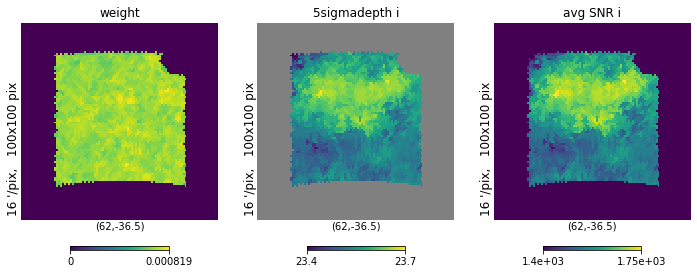

In [20]:
# View the healpix map

fig,axarr=plt.subplots(1,3,figsize=[12,6])

plt.sca(axarr[0])
hp.gnomview(weight*mask/sum(weight), rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, title="weight",
           hold=True)
plt.sca(axarr[1])
hp.gnomview(Med_5sd_i*mask, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, title="5sigmadepth i",
           hold=True)
plt.sca(axarr[2])
hp.gnomview(avg_SNR_i, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, title="avg SNR i",
            min=1400, max=1750,
           hold=True)

Now if we want to change any of the default settings, we can supply them in `ObsCondition.make_stage()`. In this example, instead of supplying the median $5\sigma$ depth in $i$-band, we supply the median airmass in $i$-band. In this case, the $i$-band limiting magnitude `m5` will be computed explicitly (notice that if `m5` is also supplied, then it will overwrite the explicitly computed `m5`).

In [21]:
airmass_degrader = ObsCondition.make_stage(
    map_dict={"airmass": "./../src/rail/examples/creation/data/survey_conditions/minion_1016_dc2_Median_airmass_i_and_nightlt1825_HEAL.fits",
             "nYrObs": 5.0}
)

In [22]:
print(airmass_degrader)

Loaded observing conditions from configuration file: 
nside = 128, 
mask file:  /global/u2/q/qhang/desc/RAIL/rail/creation/degradation/../../../examples/creation/data/survey_conditions/DC2-mask-neg-nside-128.fits, 
weight file:  /global/u2/q/qhang/desc/RAIL/rail/creation/degradation/../../../examples/creation/data/survey_conditions/DC2-dr6-galcounts-i20-i25.3-nside-128.fits, 
tot_nVis_flag = True, 
random_seed = 42, 
map_dict contains the following items: 
{'airmass': 'data/survey_conditions/minion_1016_dc2_Median_airmass_i_and_nightlt1825_HEAL.fits', 'nYrObs': 5.0}


In [23]:
data_degraded_airmass = airmass_degrader(data)

Assigning pixels.
Inserting handle into data store.  output: inprogress_output.pq, ObsCondition


In [24]:
data_degraded_airmass.data.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,pixel
0,0.905692,22.992845,0.019652,23.008888,0.008011,22.992444,0.007780,23.000725,0.010207,22.963483,0.016085,22.967855,0.035617,162135
1,0.008942,22.972841,0.018975,23.009923,0.007972,23.020776,0.007870,22.992634,0.010121,22.983570,0.016306,23.017796,0.036954,154458
2,0.629562,23.037129,0.020051,22.994301,0.007915,23.010844,0.007834,22.989520,0.010105,23.013042,0.016710,23.013801,0.036869,164170
3,1.220909,23.010959,0.019578,22.987953,0.007883,22.995835,0.007770,22.990243,0.010105,23.007511,0.016629,23.017736,0.036960,160588
4,1.987787,23.003878,0.019339,23.008493,0.007953,22.992566,0.007749,23.000657,0.010165,23.004003,0.016566,22.964613,0.035182,145763


Again, we can examine whether the spatial dependence is indeed applied. Here, `LsstErrorModel` does not have band-dependent airmass, so it affects all bands. The default airmass is $X=1.2$, but the input median airmass is more optimistic, thus reducing the magnitude errors.

In [25]:
Med_airmass_i = hp.read_map("./../src/rail/examples/creation/data/survey_conditions/minion_1016_dc2_Median_airmass_i_and_nightlt1825_HEAL.fits")

In [26]:
# Compute the average SNR in each pixel for i and r bands
avg_SNR_i_airmass = np.zeros(len(mask))
avg_SNR_r_airmass = np.zeros(len(mask))
for pix, pix_cat in (data_degraded_airmass.data).groupby("pixel"):
    avg_SNR_i_airmass[pix] = np.mean((pix_cat["i"]/pix_cat["i_err"]).to_numpy())
    avg_SNR_r_airmass[pix] = np.mean((pix_cat["r"]/pix_cat["r_err"]).to_numpy())

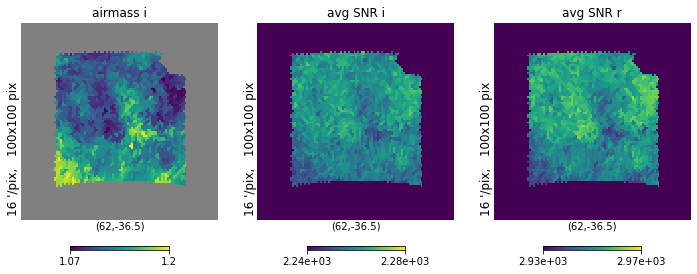

In [27]:
# View the healpix map in 

fig,axarr=plt.subplots(1,3,figsize=[12,6])

plt.sca(axarr[0])
hp.gnomview(Med_airmass_i*mask, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, title="airmass i",
           hold=True)
plt.sca(axarr[1])
hp.gnomview(avg_SNR_i_airmass, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, title="avg SNR i",
            min=2240, max=2280,
           hold=True)

plt.sca(axarr[2])
hp.gnomview(avg_SNR_r_airmass, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, title="avg SNR r",
            min=2930, max=2970,
           hold=True)

In both cases, we see a negative correlation between the airmass and the SNR in $i$ and $r$ bands, as expected.